In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow
import imutils
import hashlib

Connect to the source of data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# LOAD THE DATA

In [ ]:
def load_data(root, types, labels, image_size=200):
    """
    Loads images and their corresponding labels from the preprocessed dataset.

    Args:
        root (str): Root directory containing the preprocessed images.
        types (list): Data types (e.g., ['Training', 'Testing']).
        labels (list): List of class labels corresponding to subfolders.
        image_size (int): Size of the images (assumes square dimensions).

    Returns:
        X (list): List of flattened images.
        y (list): Corresponding labels.
    """
    X, y = [], []
    for t in types:
        for label in labels:
            path = os.path.join(root, t, label)
            if not os.path.exists(path):
                continue
            for file in os.listdir(path):
                img_path = os.path.join(path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: {img_path} could not be loaded.")
                    continue
                img = cv2.resize(img, (image_size, image_size))  # Ensure consistent size
                X.append(img.flatten())  # Flatten the image into a 1D array
                y.append(labels.index(label))
    return np.array(X), np.array(y)

In [ ]:
root = '/content/drive/MyDrive/TFM/cropped_images'
types = ['Training', 'Testing']
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
image_size = 200

In [ ]:
# Load the data
X_train, y_train = load_data(root, [types[0]], labels, image_size)
X_test, y_test = load_data(root, [types[1]], labels, image_size)

In [ ]:
#Normalize images to [0,1]
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

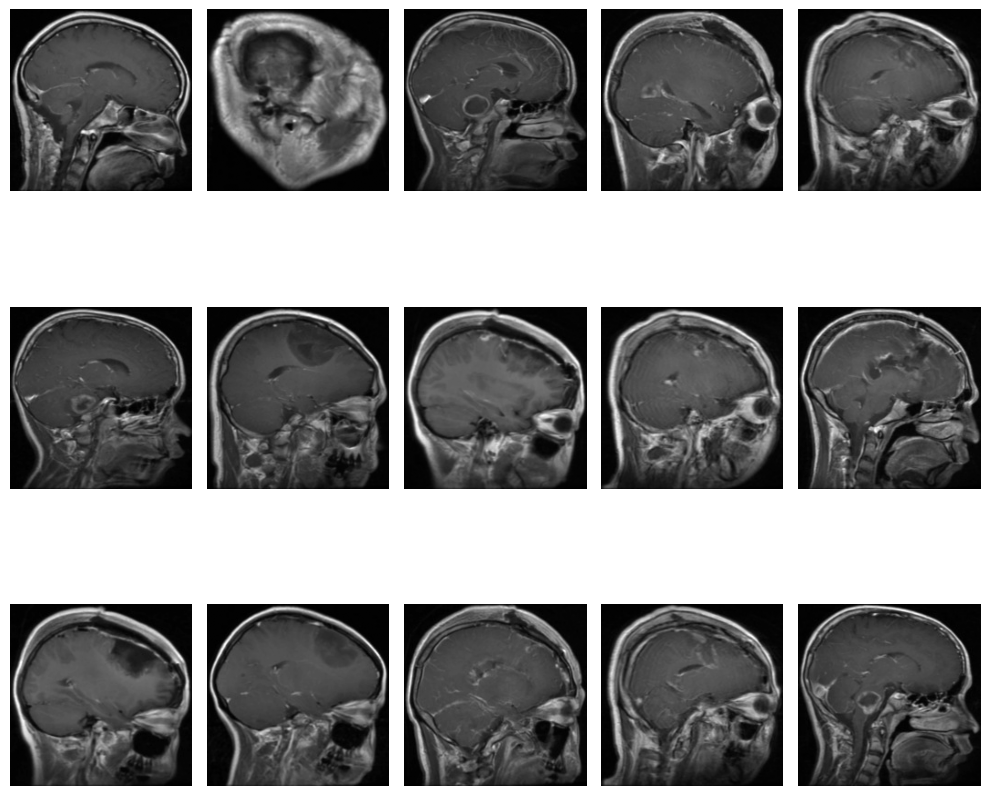

In [ ]:
# Reshape and display flattened images
images = [X_train[i].reshape(image_size, image_size) for i in range(15)]  # Reshape each image to its original size
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img, cmap='gray')  # Display the reshaped image
    ax.axis('off')  # Turn off axis labels
plt.tight_layout()
plt.show()

# TRAINING OF THE SVM MODEL

In [ ]:
# Defining the parameters grid fOr GridSearchCV to find the best parameters
param_grid={'C':[0.1,1],
            'gamma':[0.001,0.1,1],
            'kernel':['poly']}

In [ ]:
# Creating a support vector classifier
# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
svc=GridSearchCV(svc,param_grid, cv = 3, verbose=3)

In [ ]:
svc.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.789 total time=30.1min
[CV 2/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.812 total time=31.4min
[CV 3/3] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.760 total time=28.9min
[CV 1/3] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.796 total time=27.5min
[CV 2/3] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.808 total time=30.6min
[CV 3/3] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.742 total time=28.4min
[CV 1/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.796 total time=27.5min
[CV 2/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.808 total time=30.7min
[CV 3/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.742 total time=28.0min
[CV 1/3] END .....C=1, gamma=0.001, kernel=poly;, score=0.798 total time=28.3min
[CV 2/3] END .....C=1, gamma=0.001, kernel=poly;, score=0.808 total time=31.4min
[CV 3/3] END .....C=1, gamma=0.001, kernel=poly;,

GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'gamma': [0.001, 0.1, 1],
                         'kernel': ['poly']},
             verbose=3)

In [ ]:
# Test the model
print("Testing the SVM model...")
y_pred = svc.predict(X_test)

Testing the SVM model...


In [ ]:
# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[274  16   9   1]
 [ 40 244  14   8]
 [ 19   1 280   0]
 [ 10   0   1 394]]


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.91      0.85       300
  meningioma       0.93      0.80      0.86       306
   pituitary       0.92      0.93      0.93       300
     notumor       0.98      0.97      0.98       405

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



In [ ]:
from joblib import dump, load

# Save the model
model_path = '/content/drive/MyDrive/TFM/svm_model_best.joblib'  # Update with your desired path
dump(svc, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/TFM/svm_model_best.joblib
